<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/002_gbif_pitta_nympha_spatial_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

In [63]:
import geemap
import os, requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt

from google.colab import files
from google.colab import drive

In [ ]:
# 대한민국 범위 좌표 지정(좌하단 : 우상단 좌표)
rectangle_coords = [
    [125.0765578311700068, 33.1124998462386984],
    [131.8727812628719960, 38.4000004985049017],
]

# 직사각형 생성
rectangle = ee.Geometry.Rectangle(rectangle_coords)

# 직사각형을 Feature로 변환
feature = ee.Feature(rectangle)

# FeatureCollection 생성
kr = ee.FeatureCollection([feature])

m = geemap.Map(layout={'height':'400px', 'width':'800px'})
m.addLayer(kr, {}, "Republic of Korea")
m.centerObject(kr, 6)
m

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

### Dynanic World

2019년 2023년 중 5월부터 7월까지 기간의 이미지만 필터링한 후, 가장 빈번하게 나타나는 label 값, 즉 최다 빈도(most frequent)를 각 픽셀에 대해 계산하였다.

In [ ]:
# 날짜 범위 설정
start_date = '2019-05-01'
end_date = '2023-07-31'

# Dynamic World 이미지 컬렉션 필터링
dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
      .filterDate(start_date, end_date)
      .filterBounds(kr.geometry()))

In [ ]:
# ImageCollection의 이미지 개수
layer_count = dw.size().getInfo()
print(f'dw의 레이어 수: {layer_count}')

dw의 레이어 수: 15440


In [ ]:
# 5월부터 7월까지 이미지 필터링
dw_filtered = dw.filter(ee.Filter.calendarRange(5, 7, 'month'))

# ImageCollection의 이미지 개수
layer_count = dw_filtered.size().getInfo()
print(f'dw의 레이어 수: {layer_count}')

dw의 레이어 수: 3851


In [ ]:
# Dynamic World 이미지 컬렉션의 'label' 밴드 선택
classification = dw.select('label')

# 'mode' 리듀서를 사용하여 합성 이미지 생성
dw_composite = classification.reduce(ee.Reducer.mode())

In [ ]:
# 시각화 매개변수 설정
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635',
        '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1'
    ]
}

# 합성 이미지를 지리적 범위로 자르기
dw_composite_clipped = dw_composite.clip(kr.geometry())

m = geemap.Map(layout={'height':'400px', 'width':'800px'})
m.addLayer(dw_composite_clipped, dw_vis_params, 'Classified Composite')
m.centerObject(dw_composite_clipped, 9)
m

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=dw_composite_clipped,
    description='DW_2019-2023_MAY-JUL',
    folder='kari-sdm',
    scale=10,  # 이미지의 해상도
    region=kr.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(30)  # 30초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: READY
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Status: RUNNING
Polling for task (id: UITNS4K6QIDXSZSP53RV2QWM). Sta

### Dynamic World

2019년 5월부터 2023년 7월까지 총 15,440장 이미지 중 5월부터 7월까지로 한정해 3,851장이 선택되었고 최다 빈도를 통해 1장의 이미지가 생성되었다. Dynamic World의 토지 이용 및 토지 피복(Land Use and Land Cover, LULC)은 총 9개의 분류 클래스로 구성되어 있다. 본 연구에서는 GBIF(Global Biodiversity Information Facility)를 통해 수집된 각 출현 데이터 위치에 해당하는 LULC 정보를 수집하였다. 수집된 GBIF 데이터 중 Trees, Grass, Flooded vegetation, Shrub & Scrub의 4개 클래스에 해당하는 좌표는 Presence 좌표로 채택하였으며 Crops, Built Area, Bare ground 클래스에서는 Absence 좌표를 샘플링하였다. Water와 Snow & Ice 클래스는 분석 대상에서 제외하였다. Absence 좌표 샘플링을 위한 부재 마스크는 QGIS의 Raster Calculator와 Rasterize (vector to raster) 기능을 통해 생성되었다.

**Raster Calculator: Absence Mask 생성**
("DW_2019-2023_MAY-JUL@1" = 4 OR "DW_2019-2023_MAY-JUL@1" = 6 OR "DW_2019-2023_MAY-JUL@1" = 7) * 1 + ("DW_2019-2023_MAY-JUL@1" != 4 AND "DW_2019-2023_MAY-JUL@1" != 6 AND "DW_2019-2023_MAY-JUL@1" != 7) * 0

**Table 1: Classification of Land Cover Types**

| Label | Presence             | Absence           | Not Applicable   |
|-------|----------------------|-------------------|------------------|
| 1.0   | Trees                |                   |                  |
| 2.0   | Grass                |                   |                  |
| 3.0   | Flood vegetation     |                   |                  |
| 5.0   | Shrub & Scrub        |                   |                  |
| 4.0   |                      | Crops             |                  |
| 6.0   |                      | Built Area        |                  |
| 7.0   |                      | Bare ground       |                  |
| 0.0   |                      |                   | Water            |
| 8.0   |                      |                   | Snow & Ice       |

QGIS의 Sample raster values 기능을 통해 속성 필터링된 출현 좌표(pitta_nympha_filtered1.gpkg) 위치에 해당하는 Dynamic World 래스터 값을 속성 추가(pitta_nympha_filtered2.gpkg)하였다. 이때 대한민국 경계 범위를 벗어나는 경우에는 속성 값에 NULL 값이 부여된다.

In [ ]:
!wget https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_filtered2.gpkg -O pitta_nympha_filtered2.gpkg

--2024-08-13 01:11:38--  https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_filtered2.gpkg
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_filtered2.gpkg [following]
--2024-08-13 01:11:39--  https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_filtered2.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135168 (132K) [application/octet-stream]
Saving to: ‘pitta_nympha_filtered2.gpkg’

pitta_nympha_filter 100%[===================>] 132.00K  --.-KB/s    in 0.02s   

2024-08-13 01:11:39 (6.81 MB/s) - ‘pitta_nympha_filtered2.gpkg’ saved [13

In [ ]:
gdf = gpd.read_file('pitta_nympha_filtered2.gpkg')
gdf.head(1)

,species,publishingOrgKey,year,month,eventDate,DW_1,geometry
0,Pitta nympha,28eb1a3f-1c15-4a95-931a-4af90ecb574d,2023,5,2023-05-27T13:33:36,0.0,POINT (126.72514 33.20314)


In [ ]:
len(gdf)

216

이 과정에서 216개 중 NULL 값을 가지고 있는 5개 출현 좌표는 제외된다.

In [ ]:
# DW_1 필드 내 고유값의 개수/비울 계산
dw1_counts = gdf['DW_1'].value_counts().sort_index()
dw1_percentages = gdf['DW_1'].value_counts(normalize=True).sort_index() * 100

results = pd.DataFrame({
    'Count': dw1_counts,
    'Percentage': dw1_percentages
})
print(results)

      Count  Percentage
DW_1                   
0.0      18    8.530806
1.0     137   64.928910
4.0      12    5.687204
6.0      44   20.853081


In [ ]:
# Dynamic World 표준 레이블/색상 설정
label_map = {0.0: 'Water', 1.0: 'Trees', 2.0: 'Grass', 3.0: 'Flood vegetation', 4.0: 'Crops',
             5.0: 'Shrub & Scrub', 6.0: 'Built Area', 7.0: 'Bare ground', 8.0: 'Snow & Ice'}
color_map = {0.0: '#419BDF', 1.0: '#397D49', 2.0: '#88B053', 3.0: '#7A87C6', 4.0: '#E49635',
             5.0: '#DFC35A', 6.0: '#C4281B', 7.0: '#A59B8F', 8.0: '#B39FE1'}

present_labels = [label_map[key] for key in results.index if key in label_map]
present_colors = [color_map[key] for key in results.index if key in color_map]

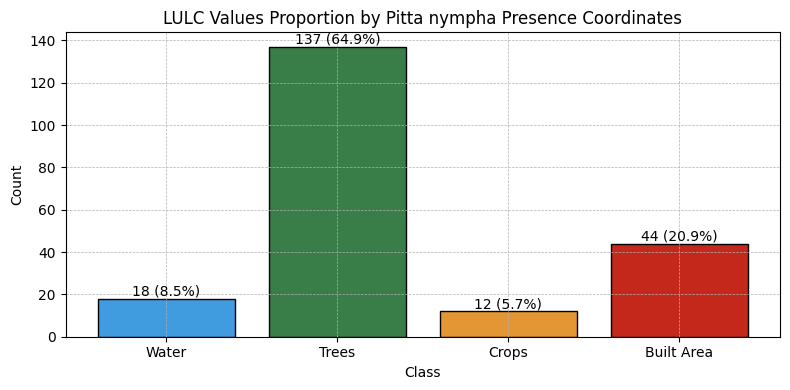

In [ ]:
# 색상/비율 바 차트
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(present_labels, results['Count'], color=present_colors, edgecolor='black')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('LULC Values Proportion by Pitta nympha Presence Coordinates')
plt.xticks()
plt.yticks()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = results.iloc[i]['Percentage']
    ax.annotate(f'{height} ({percentage:.1f}%)',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  # 0 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

출현 좌표 중 18건은 Water에, 56건은 팔색조의 부재 영역으로 정의된 Crops 및 Built Area에 위치하였다. GBIF 데이터는 다양한 출처로부터 집계되며, 대부분 시민과학 방식으로 다수의 조사자에 의해 수집된다. 따라서 조사자의 역량이 다양하고 조사방법의 차이에 따라 일부 좌표는 의도치 않은 위치를 가리킬 수 있다. 예를 들면, 특정 조류의 원거리 탐측 시, 조사자의 위치와 해당 조류의 위치는 이격되어 있음에도 실제 좌표는 조류 위치가 아닌 조사자 위치로 기록될 수 있다.

따라서 본 연구에서는 데이터의 신뢰도를 높이기 위해 팔색조가 출현할 수 있는 Trees 클래스 내 137건의 데이터만을 분석에 사용하였다. 또한, 이러한 공간 필터링이 실제 예측 정확도에 미치는 영향을 평가하기 위해 5종의 SDM 분류기를 활용하여 검증을 수행하였다.

예측 과정에서 공간 필터링에 사용된 Dynamic World는 환경변수에 사용하지 않았다. Dynamic World를 사용하여 생물종 출현 좌표를 필터링한 후, 동일한 지도를 SDM의 환경변수로 사용하는 것은 분석 과정에서 편향을 초래할 수 있다. 필터링 과정에서 이미 특정 토지피복 유형을 기준으로 데이터를 선택하였기 때문에, 동일한 지도를 환경변수로 사용할 경우 예측 모델이 필터링 과정에서 선택된 패턴을 과도하게 학습할 가능성이 있다. 이는 모델의 일반화 능력을 저해하고, 실제 예측 정확도에 부정적인 영향을 미칠 수 있다. 따라서 필터링에 사용된 토지피복지도를 환경변수로 재사용하는 것은 피하는 것이 바람직하다.

In [ ]:
# DW_1이 1인 값만 선택
gdf_filtered3 = gdf[gdf['DW_1'] == 1]
gdf_filtered3.head(1)

,species,publishingOrgKey,year,month,eventDate,DW_1,geometry
4,Pitta nympha,e2e717bf-551a-4917-bdc9-4fa0f342c530,2023,5,2023-05-27,1.0,POINT (126.69344 33.36925)


In [ ]:
len(gdf_filtered3)

137

In [ ]:
gdf_filtered3.to_file("pitta_nympha_filtered3.gpkg", driver="GPKG")
files.download('pitta_nympha_filtered3.gpkg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

종 분포 모델링에서 중요한 단계 중 하나는 인근 관측치들이 다수 존재할 경우, 데이터 집합으로 인해 모델 결과에 영향을 미칠 수 있는 지리적 샘플링 편향(geographic sampling bias)의 잠재적 효과를 제한하는 것이다. 따라서 선택된 공간해상도에 따라 각 픽셀 당 하나의 출현 기록만 임의로 선택하여 위치 데이터 간격을 넓혀 밀도를 낮추는 작업을 하는데 이것을 공간적 간격 조정(spatial thining)이라고 한다.

본 연구에서는 30m급 공간해상도를 기준으로 공간적 간격 조정을 적용하였다. 이를 위해 QGIS에서 랜덤 래스터 레이어를 생성한 후 픽셀당 1개의 출현 좌표만 임의 선택되도록 PyQGIS를 통해 구현하였다. GBIF 레이어는 특히 동일 위치에서 다수의 중복 좌표가 존재하는 경우가 있어 공간적 간격 조정의 적용은 필수적이다. 해당 작업을 통해 최종적으로 64개 좌표가 선택되었다.

In [42]:
!wget https://github.com/osgeokr/kari-sdm/raw/main/presence.gpkg -O presence.gpkg
!wget https://github.com/osgeokr/kari-sdm/raw/main/absence.gpkg -O absence.gpkg

--2024-08-13 04:06:55--  https://github.com/osgeokr/kari-sdm/raw/main/presence.gpkg
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/osgeokr/kari-sdm/main/presence.gpkg [following]
--2024-08-13 04:06:55--  https://raw.githubusercontent.com/osgeokr/kari-sdm/main/presence.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118784 (116K) [application/octet-stream]
Saving to: ‘presence.gpkg’

presence.gpkg       100%[===================>] 116.00K  --.-KB/s    in 0.01s   

2024-08-13 04:06:55 (8.59 MB/s) - ‘presence.gpkg’ saved [118784/118784]

--2024-08-13 04:06:55--  https://github.com/osgeokr/kari

In [43]:
presence = gpd.read_file('presence.gpkg')
presence.head(1)

,species,publishingOrgKey,year,month,eventDate,DW_1,raster_value_1,geometry
0,Pitta nympha,e2e717bf-551a-4917-bdc9-4fa0f342c530,2023,5,2023-05-27,1.0,1.208385,POINT (126.69344 33.36925)


In [44]:
len(presence)

64

In [45]:
absence = gpd.read_file('absence.gpkg')
absence.head(1)

,id,geometry
0,0,POINT (14081517.192 4210156.161)


In [46]:
len(absence)

64

In [47]:
print(f"Presence CRS: {presence.crs}, Absence CRS: {absence.crs}")

Presence CRS: EPSG:4326, Absence CRS: EPSG:3857


In [48]:
absence = absence.to_crs(epsg=4326)

SDM 분석은 출현-부재 데이터가 포함된 데이터셋을 사용하는 것이 항상 권장된다(Brotons et al., 2004). 따라서 모델 적합을 위해 무작위 배경 좌표(random background points) 또는 임의-부재 좌표(pseudo-absence points)를 생성해야 한다(Phillips et al., 2009). 임의-부재 좌표를 선택하는 방법의 적절성은 모델 성능에 영향을 미칠 수 있으므로 매우 중요하다(Barbet-Massin et al., 2012)




In [49]:
# presence 데이터
presence['species'] = 'Pitta nympha'
presence['status'] = 1

# absence 데이터
absence['species'] = 'Pitta nympha'
absence['status'] = 0

# 필요한 필드만 선택
presence = presence[['species', 'status', 'geometry']]
absence = absence[['species', 'status', 'geometry']]

# presence와 absence 데이터를 병합
gdf_pa_dw = pd.concat([presence, absence], ignore_index=True)

# GeoPackage 파일로 저장
gdf_pa_dw.to_file('pitta_nympha_pa_dw.gpkg', layer='data', driver="GPKG")
files.download('pitta_nympha_pa_dw.gpkg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
!wget https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_pa_dw.gpkg -O pitta_nympha_pa_dw.gpkg
gdf = gpd.read_file('pitta_nympha_pa_dw.gpkg')
gdf.head(1)

--2024-08-13 04:12:37--  https://github.com/osgeokr/kari-sdm/raw/main/pitta_nympha_pa_dw.gpkg
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_pa_dw.gpkg [following]
--2024-08-13 04:12:37--  https://raw.githubusercontent.com/osgeokr/kari-sdm/main/pitta_nympha_pa_dw.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114688 (112K) [application/octet-stream]
Saving to: ‘pitta_nympha_pa_dw.gpkg’

pitta_nympha_pa_dw. 100%[===================>] 112.00K  --.-KB/s    in 0.02s   

2024-08-13 04:12:37 (6.77 MB/s) - ‘pitta_nympha_pa_dw.gpkg’ saved [114688/114688]



,species,status,geometry
0,Pitta nympha,1,POINT (126.69344 33.36925)


In [51]:
gdf['status'].value_counts()

,count
status,
1,64
0,64


In [64]:
# Google Drive를 마운트
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/kari-sdm/KR.gpkg'

# 대한민국 경계
kr = gpd.read_file(file_path)

Mounted at /content/drive


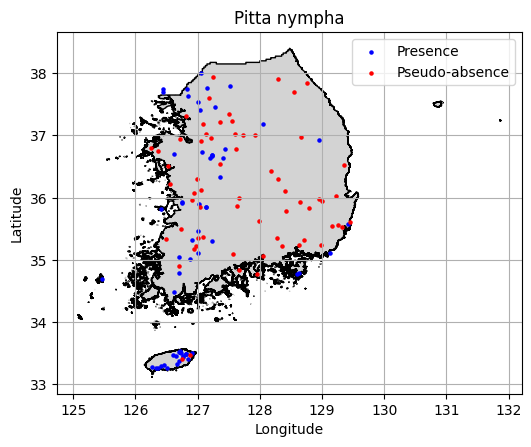

In [66]:
# presence와 absence로 데이터를 분리
presence = gdf[gdf['status'] == 1]
absence = gdf[gdf['status'] == 0]

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# 대한민국 경계
kr.plot(ax=ax, color='lightgrey', edgecolor='black')

# presence 데이터 플롯
presence.plot(ax=ax, marker='o', color='blue', markersize=5, label='Presence')

# absence 데이터 플롯
absence.plot(ax=ax, marker='o', color='red', markersize=5, label='Pseudo-absence')

# 범례, 제목, 축 레이블, 그리드 설정
plt.legend()
plt.title('Pitta nympha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

ax.set_aspect('equal', 'box')

# 플롯 표시
plt.show()